In [3]:
import os
import matplotlib.pylab as plt
from glob import glob
import numpy as np

import torch
import torch.nn.functional as F

import random

from PIL import Image

from network import U_Net

from torchvision import transforms

from utils import merge_masks, dense_crf
from utils import plot_img_and_mask

In [4]:
PATH = os.path.abspath('.')

SOURCE_IMAGES = [os.path.join(PATH, "../data/images/um")]
# SOURCE_IMAGES = [os.path.join(PATH, "../data/images/um"), 
#                  os.path.join(PATH, "../data/images/umm"), 
#                  os.path.join(PATH, "../data/images/uu")]

images = []
labels = []

for si in SOURCE_IMAGES:
    images.extend(glob(os.path.join(si, "*.png")))
    labels.extend(glob(os.path.join(si.replace("images/","labels/egolane/"), "*.png")))
    
print("Datasets used: {}\n".format(SOURCE_IMAGES))

images.sort()
labels.sort()

Datasets used: ['/home/kenny/Desktop/lanes-segmentation/torch/../data/images/um']



In [15]:
print(np.size(images))
print(np.size(labels))

95
95


In [16]:
def crop(x, crop_h, crop_w):
    h,w = x.shape[:2]
    h_new = h-crop_h, h
    w_new = int(math.floor((w-crop_w)/2.)), int(math.floor(w-(w-crop_w)/2.))
    return x[h_new[0]:h_new[1], w_new[0]:w_new[1], :]

def hwc_to_chw(img):
    return np.transpose(img, axes=[2, 0, 1])


def normalize(x):
    return np.float32(x/255.)

In [17]:
def get_image(path):
    
    image = plt.imread(path, 0)
    
    return(np.asarray(image))

In [18]:
from sklearn.model_selection import train_test_split

test_size = 0.25
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=test_size, random_state=1)

del(images_train, labels_train)

In [24]:
x_test = []

for i in images_test:
    x_test.append(get_image(i))

x_test = np.asarray(x_test)

In [26]:
x_test = x_test[:10]

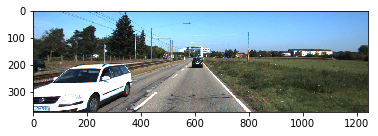

In [33]:
plt.imshow(x_test[0])

In [27]:
net = U_Net(img_ch=3, output_ch=1)
net.cpu()
net.load_state_dict(torch.load("checkpoints/CP99.pth", map_location='cpu'))
net.eval()

U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (Conv3): conv

In [28]:
y_pred = np.zeros([len(x_test), 320, 1152], dtype=np.float32)

for i in range(len(x_test)):
    X = torch.from_numpy(hwc_to_chw(normalize(x_test[i]))).unsqueeze(0)
    with torch.no_grad():
        output = net(X)

        probs = output.squeeze(0)

        tf = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.ToTensor()
            ]
        )

        probs = tf(probs.cpu())

        y_pred[i] = probs.squeeze().cpu().numpy()

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 93 and 92 in dimension 2 at /home/kenny/Desktop/pytorch/aten/src/TH/generic/THTensorMoreMath.cpp:1317

In [ ]:
y_pred = y_pred > 0.5

In [ ]:
import webcolors

def colorize(mask):
    hex_colors = ['#000000', '#50E3C2']

    rgb_colors = []

    for hex_color in hex_colors:
        rgb_colors.append(webcolors.hex_to_rgb(hex_color))
        
    colors = np.array(rgb_colors)
        
    colorMask = np.zeros([mask.shape[0], mask.shape[1], 3],dtype=np.uint8)
    for r in range(mask.shape[0]):
        for c in range(mask.shape[1]):
            colorMask[r,c,] = colors[mask[r,c]]

    return colorMask

In [ ]:
n = 0

fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(15,10)
axes[0].imshow(get_image(images_test[n]))
axes[1].imshow(colorize(get_image(labels_test[n])))
axes[2].imshow(colorize(np.array(y_pred[n], dtype=np.int32)))
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(15,10)
for i in range(len(x_test)):
    axes[0].set_title('RGB Image')
    axes[1].set_title('GT Mask')
    axes[2].set_title('Prediction Mask')
    axes[0].imshow(get_image(images_test[i]))
    axes[1].imshow(colorize(get_image(labels_test[i])))
    axes[2].imshow(colorize(np.array(y_pred[i], dtype=np.int32)))
    fig.tight_layout()
    fig.savefig('results/egolane/U_Net/img{}.png'.format(i))